In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

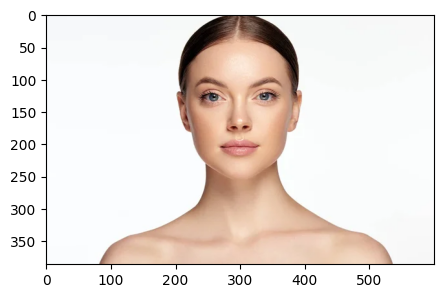

In [5]:
face = cv2.imread("../images/face.jpg")
face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5, 5))
plt.imshow(face)
plt.show()

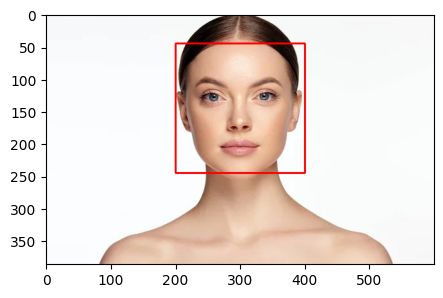

In [6]:
detector = cv2.CascadeClassifier("../data/haarcascade_frontalface_default.xml")
results = detector.detectMultiScale(face, 1.3, 5)
face_copy = np.copy(face)
for (x, y, w, h) in results:
    cv2.rectangle(face_copy, (x, y), (x+w, y+h), (255, 0, 0), 2)

plt.figure(figsize=(5, 5))
plt.imshow(face_copy)
plt.show()



In [ ]:
# segment out the face using grabcut
